<img src="img/tf.jpg" width="600" height="600"></img>

<h1>Prepare the data</h1>

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [29]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

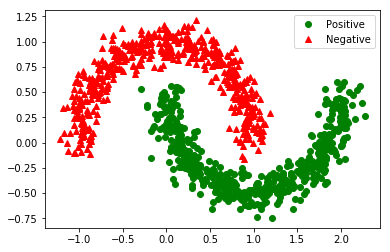

In [14]:
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [15]:
# Add an extra bias feature
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [16]:
# Reshape y_moon to make it a 2D column vector
y_moons_column_vector = y_moons.reshape(-1, 1)

In [17]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_moons_with_bias, y_moons_column_vector, test_size=int(m * 0.2), random_state=42)

In [18]:
# Function to generate small batches
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

<h1>Build the model</h1>

In [20]:
n_inputs = 2

In [21]:
# PLACEHOLDERS --> they just hold information about the type and the shape of the tensor they represent, but they have NO VALUE.
# Placeholders are typically used to feed training or test data to TF during the execution phase, or to pass a value to an
# assignment node, to change the value of a variable.

# VARIABLES --> operations that hold a value

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)

In [22]:
# Cost function
loss = tf.losses.log_loss(y, y_proba)

In [23]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [24]:
# Let's initialize the variables
init = tf.global_variables_initializer()

In [25]:
# Training
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.88805985
Epoch: 100 	Loss: 0.3566633
Epoch: 200 	Loss: 0.30963725
Epoch: 300 	Loss: 0.28806105
Epoch: 400 	Loss: 0.27569157
Epoch: 500 	Loss: 0.26814982
Epoch: 600 	Loss: 0.26314527
Epoch: 700 	Loss: 0.25927857
Epoch: 800 	Loss: 0.25715715
Epoch: 900 	Loss: 0.2549757


In [26]:
# Now y_proba_val contains the estimated probability that a single instance belongs to the positive class
# Let's classify as positive any instance greater or equal to 0.5
y_pred = (y_proba_val >= 0.5)

In [27]:
from sklearn.metrics import precision_score, recall_score

print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Precision:  0.8640776699029126
Recall:  0.89


<h1>More TF's features</h1>
- Name Scope: to group related nodes;
- Saver: to save checkpoints at regular intervals during training;
- Restore: to restore the last checkpoint if training was interrupted;
- Summaries: to visualize the learning curves in TensorBoard.

In [76]:
# Let's transform our data by adding features to improve the model
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [77]:
reset_graph()

In [78]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [79]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [81]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [82]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.63731164
Epoch: 500 	Loss: 0.14843586
Epoch: 1000 	Loss: 0.10520809
Epoch: 1500 	Loss: 0.083791636
Epoch: 2000 	Loss: 0.07074811
Epoch: 2500 	Loss: 0.061856724
Epoch: 3000 	Loss: 0.05539893
Epoch: 3500 	Loss: 0.050437964
Epoch: 4000 	Loss: 0.046511345
Epoch: 4500 	Loss: 0.043283634
Epoch: 5000 	Loss: 0.040572885
Epoch: 5500 	Loss: 0.038299955
Epoch: 6000 	Loss: 0.036324874
Epoch: 6500 	Loss: 0.034594968
Epoch: 7000 	Loss: 0.033107374
Epoch: 7500 	Loss: 0.031753913
Epoch: 8000 	Loss: 0.030531855
Epoch: 8500 	Loss: 0.029434452
Epoch: 9000 	Loss: 0.028495492
Epoch: 9500 	Loss: 0.027590923
Epoch: 10000 	Loss: 0.026702605


In [83]:
y_pred = (y_proba_val >= 0.5)

In [86]:
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Precision:  1.0
Recall:  0.99


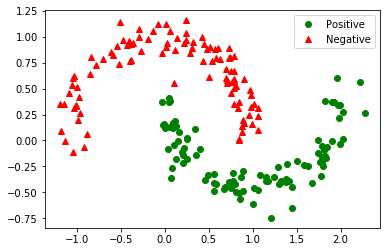

In [87]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now in the cmd you can type 

<i>$ tensorboard --logdir=tf_logs</i>

to see the learning curve.